# Различные методы оптимизации для решения линейной регрессии
<h2>Седых Иван Дмитриевич БПМ185</h2>

## Импорт нужных библиотек

In [1]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

## Сгенерируем данные 
Генерируются они по следующему правилу: 
$$
y = w_1x+w_0+\epsilon
$$
Где:  
$w$ - коэффициенты, в нахождении которых и заключается задача  
$\epsilon$ - гауссовский шум с $\sigma=$ `noise`, $\mu=0$ 

In [2]:
b = 20
X, y, coefs = make_regression( 
                        n_samples=100, #названия парметров 
                        n_features=1,
                        bias=b,
                        noise=5,
                        coef=True,
                        random_state=42
                        )

# Приделаем справа столбец из единиц, чтобы формула регрессии приняла вид: y=aX
X = np.hstack((X,np.ones((X.shape[0],1))))

coefs = np.array([coefs, b])
print('искомые коэффициенты:')
print(coefs)

искомые коэффициенты:
[41.74110031 20.        ]


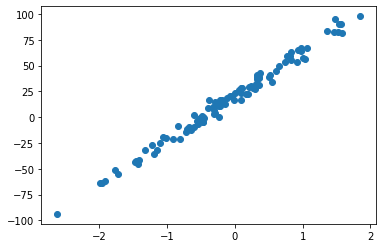

In [3]:
plt.scatter(X[:,:-1],y)
plt.show()

## Определим функцию которую будем оптимизировать  
Стандарт для задачи регресии - $MeanSquaredError (MSE)$ 
$$
MSE(y,\hat{y}) = \frac{1}{l}\sum_{i=1}^{l} (y_i-\hat{y_i})^2 
$$
или, для нашего случая: $$MSE(X,y) = \frac{1}{l}\sum_{i=1}^{l} (y_i-x_iw)^2$$

In [4]:
def mse(w0,w1):
    return np.mean(
        np.power(
            X@np.array([w1,w0]) - y, 2
        )
    )

## Построим график функции потерь  
Видно, что она гладкая выпуклая и вообще хорошая с одним минимумом, который является глобальным

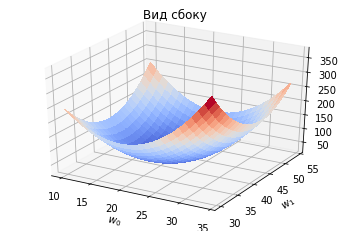

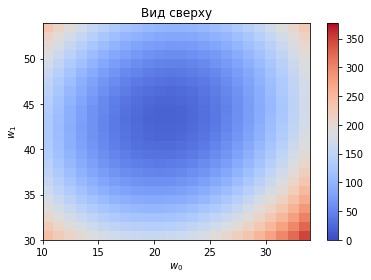

In [16]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
xx = np.arange(10, 35, 1)
yy = np.arange(30, 55, 1)
xx, yy = np.meshgrid(xx, yy)
Z = np.vectorize(mse)(xx,yy)

# Plot the surface.
surf = ax.plot_surface(xx, yy, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.xlabel('$w_0$')
plt.ylabel('$w_1$')
plt.title('Вид сбоку')
plt.show()

fig, ax = plt.subplots()

z_min, z_max = 0, np.abs(Z).max()
c = ax.pcolormesh(xx, yy, Z, cmap=cm.coolwarm, vmin=z_min, vmax=z_max)
ax.set_title('Вид сверху')
ax.axis([xx.min(), xx.max(), yy.min(), yy.max()])
fig.colorbar(c, ax=ax)
plt.xlabel('$w_0$')
plt.ylabel('$w_1$')
plt.show()

## Аналитическое решение 
Для этой задачи можно получить аналитическое решение явно, продифференцировав функционал ошибки (уберем множитель $\frac{1}{l}$, минимум от этого не изменится). 
$$
l \cdot MSE = (y-Xw)^T(y-Xw)
$$
Дифференцируя эту функцию по вектору параметров $w$ и приравняв производные к нулю,
$$
\frac{\partial MSE}{\partial w} = -2 X^T y+2X^TXw =0 
$$
 получим систему уравнений
$$
(X^TX)w=X^Ty
$$
Решение которой:$$w =(X^TX)^{-1}X^Ty $$


In [6]:
w = np.linalg.inv(X.T @ X) @ X.T @ y
print('полученное решение:', w)
print('MSE = {}'.format(mse(*w[::-1])))

полученное решение: [43.08913515 20.58255766]
MSE = 19.513562605309758


Зачем тогда, собственно, нужны другие методы оптимизации?  
Дело в том, что взятие обратной матрицы может быть проблематично (это сложная операция - $O(n^3)$, если без ухищрений) или вообще не определено, если матрица вырождена. К тому же, если матрица $X$ - большая, то быть может есть смысл использовать не все её значения, что неминуемо приводит нас к следующему методу 

## Стохастический градиентный спуск (SGD)

__Небольшая справка об обычном градиентном спуске:__  
_При стандартном градиентном спуске для корректировки параметров модели используется градиент. Градиент обычно считается как сумма градиентов, вызванных каждым элементом обучения. Вектор параметров изменяется в направлении антиградиента с заданным шагом. Поэтому стандартному градиентному спуску требуется один проход по обучающим данным до того, как он сможет менять параметры._  
  
__Объяснении на пальцах:__ Представим, что наша функция потерь (трехмерный график выше -) _ это гора, а мы стоим в случайном месте на лыжах. Теперь катимся вниз(вниз - это по направлению антиградиента). Через какое-то время мы скатимся вниз - это и будет локальный минимум.  

__Теперь о стохастическом градиентном спуске:__  
_При стохастическом (или «оперативном») градиентном спуске значение градиента аппроксимируются градиентом функции стоимости (потерь, в нашем случае MSE), вычисленном только на одном элементе обучения. Затем параметры изменяются пропорционально приближенному градиенту. Таким образом параметры модели изменяются после каждого объекта обучения. Для больших массивов данных стохастический градиентный спуск может дать значительное преимущество в скорости по сравнению со стандартным градиентным спуском._  

Формула для шага градиентного спуска в нашем случае выглядит так:
$$w = w - \eta \nabla MSE $$
или
$$
w_i = w_i - \eta \frac{\partial MSE}{\partial w_i}
$$
[source](http://www.machinelearning.ru/wiki/index.php?title=%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D1%81%D1%82%D0%BE%D1%85%D0%B0%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B3%D0%BE_%D0%B3%D1%80%D0%B0%D0%B4%D0%B8%D0%B5%D0%BD%D1%82%D0%B0)  

полученное решение: [43.08308701 20.57648821]
MSE = 19.513622082287583


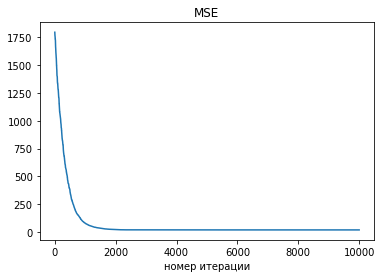

CPU times: user 1.09 s, sys: 28.9 ms, total: 1.12 s
Wall time: 1.29 s


In [7]:
%%time
history = np.array([])
w = np.zeros(shape=X.shape[1])
lr = 1e-3

steps = 10000 
for _ in range(steps):
     random_id = np.random.choice(X.shape[0])
     xi = X[random_id]
     yi = y[random_id]
     grad_w0 = -2 * (yi - xi @ w[::-1])
     grad_w1 = -2 * xi[0]* (yi - xi @ w[::-1])
     w[0] = w[0] - lr * grad_w0
     w[1] = w[1] - lr * grad_w1
     history = np.append(history, mse(*w))
print('полученное решение:',w[::-1])
print('MSE = {}'.format(history[-1]))
plt.title('MSE')
plt.xlabel('номер итерации')
plt.plot(history)
plt.show()

УРА! Алгоритм сошелся к минимуму! Решение похоже на полученное аналитически.  
Хороший метод, но он имеет свои недостатки:  
* Так как алгоритм сходится к локальному минимуму, то, возможно, что найденный минимум не глобальный
* Может не сойтись

## Классический градиентный спуск  
Легко можно трансформировать стохастический градиентный спуск в классический

полученное решение: [43.08912778 20.5825542 ]
MSE = 19.5135626053614


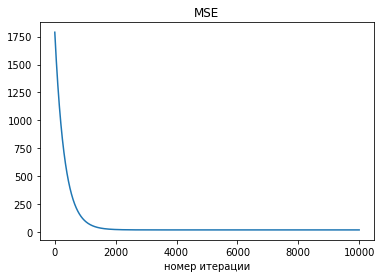

CPU times: user 1.04 s, sys: 25.1 ms, total: 1.06 s
Wall time: 1.15 s


In [8]:
%%time
history = np.array([])
w = np.zeros(shape=X.shape[1])
lr = 1e-3

steps = 10000
for _ in range(steps):
     grad_w0 = -2 * (y - X @ w[::-1]).mean()
     grad_w1 = -2 * (X[:,0] * (y - X @ w[::-1])).mean()
     w[0] = w[0] - lr * grad_w0
     w[1] = w[1] - lr * grad_w1
     history = np.append(history, mse(*w))
print('полученное решение:',w[::-1])
print('MSE = {}'.format(history[-1]))
plt.title('MSE')
plt.xlabel('номер итерации')
plt.plot(history)
plt.show()

Также в наше время постоянно придумываются новые методы, схожие с градиентным спуском, типа Adam, RMSprop, Adadelta и прочие. Их используют в глубоком обучении, где нужно эффективно оптимизировать функции очень(__очень__) многих переменных. Оценить масштаб происходящего можно в документации к разделу оптимизаторов библиотеки [Pytorch](https://pytorch.org/docs/stable/optim.html).  
Но моя работа не об этом, я сконценитрируюсь на более глубоком понимании классических методов.

## Метод Ньютона  
Формула дла шага метода Ньютона выглдядит так:
$$
w = w - H^{-1}(w)\nabla MSE(w)
$$
где $H$ - гессиан $MSE$ 
$$
\nabla MSE(w) = \begin{pmatrix}
 -2 \frac{1}{l} \sum_{i=1}^l y_i - x_iw \\
 -2 \frac{1}{l} \sum_{i=1}^l x_i(y_i - x_iw) 
  \end{pmatrix}
$$
$$
H = \begin{pmatrix}
2 & 2 \frac{1}{l} \sum_{i=1}^l  x_i \\
2 \frac{1}{l} \sum_{i=1}^l  x_i & 2 \frac{1}{l} \sum_{i=1}^l  x_i^2
\end{pmatrix}
$$

полученное решение: [43.08913515 20.58255766]
MSE = 19.513562605309744


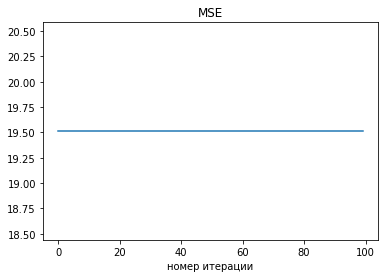

CPU times: user 422 ms, sys: 26 ms, total: 448 ms
Wall time: 432 ms


In [9]:
%%time
history = np.array([])
w = np.zeros(shape=X.shape[1])

steps = 100
for _ in range(steps):
     grad = np.array([-2 * (y - X @ w[::-1]).mean(),
                      -2 * (X[:,0] * (y - X @ w[::-1])).mean()
                    ])
     H = np.array(
         [
             [2, 2*np.mean(X[:,0])],
             [2*np.mean(X[:,0]), 2*np.mean(X[:,0]**2)]
         ]
     )
     w = w - np.linalg.inv(H)@grad
     history = np.append(history, mse(*w))
print('полученное решение:',w[::-1])
print('MSE = {}'.format(history[-1]))
plt.title('MSE')
plt.xlabel('номер итерации')
plt.plot(history)
plt.show()

### Хммммм....
Судя по всему, алгоритм нашел лучшее решение уже после первой итерации, причем оно в точности совпадает с полученным аналитически. Какой из этого можно сделать вывод?  
Метод Нютона относится к методам оптимизации второго порядка(в них используется Гессиан). А для них доказано, что в случае квадратичной функции, они находят экстремум за 1 итерацию, что, собственно, я и получил. Мне следовало бы учесть этот факт заранее, но, увы, курса по методам оптимизации у меня пока не было, поэтому знания я получал в процессе работы.  

В планах у меня был разбор квази-ньютоновских методов типа __BFGS__ (они называются квазиньютоновскими, потому что в них Гессиан не вычисляется напрямую, а используется некоторая его аппроксимация), но после полученного выше результата реализовывать их мне стало неинтересно, поэтому рассмотрим методы нулевого и первого порядка.

In [10]:
from scipy.optimize import minimize


def super_mse(w):
    return ((X@w - y)**2).mean()

np.random.seed(42)
x0 = np.random.randn(2)
minimize(super_mse, x0, method='BFGS')

      fun: 19.513562605309847
 hess_inv: array([[0.61234345, 0.0635944 ],
       [0.0635944 , 0.50660863]])
      jac: array([ 9.53674316e-07, -2.38418579e-07])
  message: 'Optimization terminated successfully.'
     nfev: 40
      nit: 7
     njev: 10
   status: 0
  success: True
        x: array([43.08913541, 20.58255745])

## Метод Нелдера — Мида  

На мой взгляд, очень красивый метод безусловной (использует только значения функции) оптимизации. Как работает?  
Создается случаный симплекс(в нашем двумерном случае, это просто треугольник). Считается значение функции в точках - вершинах треугольника, дальше происходит череда отражений-растяжений-сжатий, в результате которых мы получаем симплекс, который ближе к минимуму.  

Можно выделить основыне особенности алгоритма:  
• Функция не обязана быть гладкой   
• Удобно использовать этот метод, когда вычислять значение функции тяжело, так как он делает примерно 3 вычисления на каждой итерации  
• Можно использовать для дискретной оптимизации  
• Может сойтись к локальному минимуму :(  
• Теоретическая сходимость метода не доказана, то есть никто не гарантирует его сходимость


In [11]:
minimize(super_mse, x0, method='Nelder-Mead')

 final_simplex: (array([[43.08916464, 20.58254066],
       [43.08909447, 20.58255763],
       [43.08910618, 20.58251746]]), array([19.51356261, 19.51356261, 19.51356261]))
           fun: 19.513562606422354
       message: 'Optimization terminated successfully.'
          nfev: 147
           nit: 79
        status: 0
       success: True
             x: array([43.08916464, 20.58254066])

полученное решение: [43.08526461 20.58486516]
MSE = 19.513582178760267


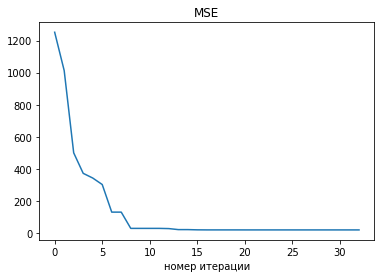

CPU times: user 309 ms, sys: 11.4 ms, total: 320 ms
Wall time: 365 ms


In [12]:
%%time
alpha = 1
beta = 0.5
gamma = 2
maxiter = 50
eps = 1e-5

# подготовка
v = np.array([
    [1,2],
    [4,2],
    [5,6.5]
    ])
history = np.array([])

i = 0
# for i in range(maxiter):
while i < maxiter and np.var(v, axis=0).mean() > eps :
    i += 1
    # сортируем точки симплекса по убыванию функции
    values = np.vectorize(mse)(v[:,0],v[:,1])
    ind = np.argsort(values).reshape(-1,1)[::-1]
    v = np.take_along_axis(v, ind, axis=0)
    history = np.append(history, mse(*v[-1]))

    fh = mse(*v[0])
    fg = mse(*v[1])
    fl = mse(*v[2])
    # считаем центр масс симплекса
    xc = v[1:].mean(axis=0)

    # отражаем худшую точку относительно симплекса
    xr = (1 + alpha) * xc - alpha * v[0]
    fr = mse(*xr)

    # если в отраженной точке значение меньше чем в лучшей
    if fr < fl:
        # пробуем растянуть
        xe = (1 - gamma) * xc + gamma * xr
        fe = mse(*xe)
        if fe < fr:
            #расширим симплекс
            v[0] = xe
            continue
        if fr < fe:
            # оставим просто отраженный
            v[0] = xr
            continue
    if fl < fr and fr < fg:
        v[0] = xr
        continue
    if fg < fr and fr < fh:
        xr, v[0] = v[0], xr
        fh, fr = fr, fh

    # сжатие
    xs = beta * v[0] + (1 - beta) * xc
    fs = mse(*xs)

    if fs < fh:
        v[0] = xs
        continue
    if fs > fh:
        for j in range(2):
            v[j] = v[2] + (v[j] - v[2])/2


w = v[-1]
print('полученное решение:',w[::-1])
print('MSE = {}'.format(history[-1]))
plt.title('MSE')
plt.xlabel('номер итерации')
plt.plot(history)
plt.show()

__УРАААА!!!!__  
Алгоритм сошелся к уже известному нам решению (отладка заняла кучу времени, так что на работу я потратил точно больше 10 часов :-))  
Причем для хорошего решения хватает уже 20 итераций

## Алгоритм имитации отжига  
Алгоритм подсмотрен у природы, а именно авторы вдохновлялись процессом кристаллизации вещества, когда переходы атомов из одного состояния в другое происходят с некоторой вероятностью, которая хитро считается и изменяется во времени. Посмотреть подробнее можно в [вики](https://ru.wikipedia.org/wiki/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%B8%D0%BC%D0%B8%D1%82%D0%B0%D1%86%D0%B8%D0%B8_%D0%BE%D1%82%D0%B6%D0%B8%D0%B3%D0%B0)

In [13]:
# генерировать случайное приближение 
r = 100
def generate_new(cur_w, cur_T):
    return np.random.random_sample(2) * (2 * r) * cur_T + cur_w - r * cur_T 

# распределение гиббса
def gibbs_pdf(x):
    return np.exp(-x)

### Моя реализация  
Температура убывает по закону: 
$$
T = \alpha T, \alpha \in (0,1)
$$  
Новая точка выбирается __ИЗОБРЕТЕННОЙ МНОЮ__ эвристикой.  
А именно, введем радиус поиска $r$, затем будем выбирать новую точку $w^*$ из равномерного распределения $w^* \sim \mathcal{U}(w-rT,w+rT)$ , что можно интерпретировать так: выбирается случайная точка вокруг текущего приближения из диапозона, который убывает вместе с температурой.  
Затем считается $MSE(w*)$. Если новое приближение оказалось лучше предыдущего $MSE(w^*)<MSE(w)$, то принимаем новое приближение и переходим к следующей итерации. Иначе решение о переходе принимается по правилу:
$$
\exp \left( -\frac{MSE(w^*) - MSE(w)}{T} \right)  > 0.5
$$

полученное решение: [43.0658111  20.67378853]
MSE = 19.522777685764837


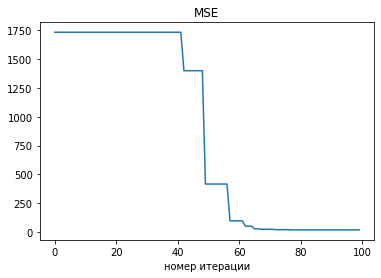

CPU times: user 311 ms, sys: 12.7 ms, total: 324 ms
Wall time: 337 ms


In [14]:
%%time
# начальная температура
T = 100
# насколько будет убывать температура
alpha = 0.9
# инициализация
w = np.random.random_sample(2)
history = np.array([])

i_max = 100
i = 0
while i < i_max:
    history = np.append(history, mse(*w))
    T = T * alpha
    w_new = generate_new(w, T)
    f_cur = mse(*w)
    f_new = mse(*w_new)
    delta_f = f_new - f_cur
    if delta_f < 0:
        w = w_new
    else:
        if gibbs_pdf(delta_f / T) > 0.5:
            w = w_new
    i += 1


print('полученное решение:',w[::-1])
print('MSE = {}'.format(history[-1]))
plt.title('MSE')
plt.xlabel('номер итерации')
plt.plot(history)
plt.show()

УРА! Алгоритм сошелся к минимуму! Теперь обсудим особенности метода:  
• Не требует гладкости функции  
• Может использоваться дл дискретной, комбинаторной оптимизации  
• Может сам выпрыгнуть из локальных минимумов благодаря случайности невыгодных переходов  
• Может не сойтись, тогда можно попробовать выбрать другое начальное приближение

## Итоги  
Мы рассмотрели некоторые методы оптимизации на примере задачи нахождения коэффициентов линейной регрессии, это было достаточно увлекательно. Все методы успешно сработали и решили задачу. В дальнейшем можно провести рефакторинг кода, оптимизировать вычисления `NumPy`, подумать над критериями останова, потому что во многих методах я просто фиксировал количество итераций.